In [69]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import *
import os
import csv

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [70]:

score = spark.read.parquet("../data/curated/score_table")

In [71]:
score.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- merchant_rev_score: double (nullable = true)
 |-- category_rev_score: double (nullable = true)
 |-- fraud_score: double (nullable = true)
 |-- trend_score: double (nullable = true)
 |-- variance_score: double (nullable = true)



In [72]:
rank = score.withColumn("score_merchant", 
        col("merchant_rev_score")*col("fraud_score")*0.7+
        col("variance_score")*0.3 + col("trend_score")*0.2)
rank = rank.withColumn("score_category", 
        col("category_rev_score")*col("fraud_score")*0.7+
        col("variance_score")*0.3 + col("trend_score")*0.2)

In [73]:
rank = rank.select("merchant_name","category","score_merchant", "score_category").sort(desc("score_merchant"))

In [74]:
rank.write.csv("../data/result")

### Top 100 merchants

In [75]:
rank.sort(desc("score_merchant")).limit(100).show(truncate = False)

+------------------------------+-----------------------+------------------+------------------+
|merchant_name                 |category               |score_merchant    |score_category    |
+------------------------------+-----------------------+------------------+------------------+
|Diam Eu Dolor LLC             |outdoors               |1.0834354600919873|1.074172225288055 |
|Arcu Morbi Institute          |art and gifts          |1.0219391156856141|1.0193048666593856|
|Ornare Limited                |outdoors               |1.0171169529219695|1.0171169529219695|
|Iaculis Aliquet Diam LLC      |outdoors               |0.9616190164575718|0.9574315742977271|
|Leo In Consulting             |fashion and accessories|0.9426120375801823|0.9404063030211498|
|Arcu Sed Eu Incorporated      |home and technology    |0.9375400556211418|0.937612083212335 |
|Dictum Phasellus In Institute |art and gifts          |0.9344189627350707|0.9309275343167138|
|Suspendisse Non Leo PC        |outdoors          

In [93]:
cat_distribution = rank.limit(100).groupBy(["category"]).agg(count(F.col("score_merchant")).alias("Number"))

#### Distribution of Category

In [94]:
cat_distribution.sort(desc("number"))

category,Number
outdoors,27
home and technology,21
art and gifts,19
fashion and acces...,17
books and music,16


In [114]:
cat = list(cat_distribution.select("category").distinct().toPandas()["category"])
num = list(cat_distribution.select("Number").distinct().toPandas()["Number"])
cat

['outdoors',
 'art and gifts',
 'fashion and accessories',
 'home and technology',
 'books and music']

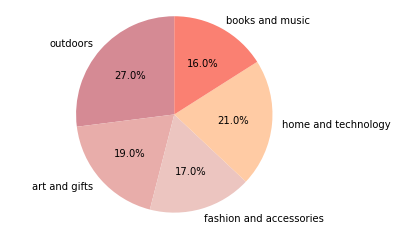

In [127]:
import matplotlib.pyplot as plt
labels = cat
sizes = num
explode = (0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, 
        colors = ["#D58A94", "#E8ADAA", "#ECC5C0", "#FFCBA4", "#FA8072"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### Information of the top 1

In [100]:
top = rank.first()["merchant_name"]

In [152]:
df_old = spark.read.parquet('../data/curated/merchant_consumer_abs')
df_info = spark.read.parquet('../data/meta/merchant_metadata.parquet')
df_predict = spark.read.parquet("../data/curated/predictions.parquet")

In [113]:
df_info.filter(F.col("merchant_name") == top)

merchant_name,revenue_level,avg(median_age),avg(sum(Undisclosed)),avg(sum(Female)),avg(sum(Male)),category,take_rate
Diam Eu Dolor LLC,b,45.283464315269356,17.95,78.15,77.85,outdoors,4.1


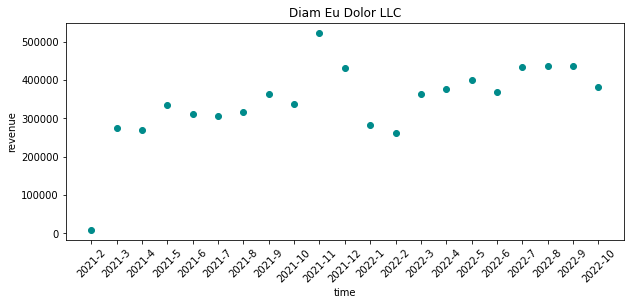

In [157]:
import numpy as np

revenue_monthly = df_old[df_old["merchant_name"] == top].groupBy(["merchant_name", "order_year", "order_month"]).agg(sum("dollar_value").alias("total_dollar_value"))
revenue_monthly = revenue_monthly.toPandas()
revenue_monthly = revenue_monthly.sort_values(["order_year", "order_month"])
revenue_monthly["period"] = revenue_monthly["order_year"].astype(str) + "-" + revenue_monthly["order_month"].astype(str)

x1 = revenue_monthly['period']
y1 = revenue_monthly['total_dollar_value']

plt.figure(figsize=(10,4))
plt.scatter(x1, y1, color="darkcyan")
plt.xticks(rotation=45)
plt.title(top)
plt.xlabel("time")
plt.ylabel("revenue")
plt.show()

### Top 10 for each category

In [82]:
outdoors = rank.filter(F.col("category") == "outdoors")
outdoors.sort(desc("score_category")).limit(10).show(truncate = False)

+------------------------------+--------+------------------+------------------+
|merchant_name                 |category|score_merchant    |score_category    |
+------------------------------+--------+------------------+------------------+
|Diam Eu Dolor LLC             |outdoors|1.0834354600919873|1.074172225288055 |
|Ornare Limited                |outdoors|1.0171169529219695|1.0171169529219695|
|Iaculis Aliquet Diam LLC      |outdoors|0.9616190164575718|0.9574315742977271|
|Suspendisse Non Leo PC        |outdoors|0.9340002676580152|0.9353052751602505|
|Auctor Company                |outdoors|0.9212027572083249|0.9226277859186572|
|Lorem Ipsum Sodales Industries|outdoors|0.89822213668196  |0.900133390996232 |
|Est Nunc Consulting           |outdoors|0.8959517141527263|0.896181822160309 |
|Erat Vitae LLP                |outdoors|0.8699137555416562|0.8725733534445631|
|Sit Amet PC                   |outdoors|0.821920856954474 |0.8251699924398127|
|Non Vestibulum Industries     |outdoors

In [83]:
home = rank.filter(F.col("category") == "home and technology")
home.sort(desc("score_category")).limit(10).show(truncate = False)

+------------------------------+-------------------+------------------+------------------+
|merchant_name                 |category           |score_merchant    |score_category    |
+------------------------------+-------------------+------------------+------------------+
|Arcu Sed Eu Incorporated      |home and technology|0.9375400556211418|0.937612083212335 |
|Interdum Feugiat Sed Inc.     |home and technology|0.9280969717055055|0.9278886122582232|
|Mauris Non Institute          |home and technology|0.9174364469087235|0.9188463569215075|
|Phasellus At Limited          |home and technology|0.9040272022614287|0.9052398370969218|
|Phasellus Dapibus Incorporated|home and technology|0.8978021888736906|0.8966225372585616|
|Neque Sed Dictum Incorporated |home and technology|0.8680456721807364|0.8664857955494034|
|Nullam Enim Ltd               |home and technology|0.8253631173119247|0.8338501285990034|
|Adipiscing Elit Foundation    |home and technology|0.8128215673386765|0.8126714000458563|

In [84]:
fashion = rank.filter(F.col("category") == "fashion and accessories")
fashion.sort(desc("score_category")).limit(10).show(truncate = False)

+-----------------------------+-----------------------+------------------+------------------+
|merchant_name                |category               |score_merchant    |score_category    |
+-----------------------------+-----------------------+------------------+------------------+
|Leo In Consulting            |fashion and accessories|0.9426120375801823|0.9404063030211498|
|Nec Tellus Ltd               |fashion and accessories|0.9320620238502593|0.9315625800084967|
|Dignissim Maecenas Foundation|fashion and accessories|0.9090690513649663|0.9099054174688489|
|Gravida Mauris Incorporated  |fashion and accessories|0.8591273551339685|0.8594936878733727|
|Dolor Quisque Inc.           |fashion and accessories|0.8253596149608865|0.8257661176904908|
|Suspendisse Dui Corporation  |fashion and accessories|0.7985965647041804|0.8004930079915684|
|Iaculis LLC                  |fashion and accessories|0.7470855112867925|0.7472295426668849|
|Blandit At LLC               |fashion and accessories|0.695

In [85]:
books = rank.filter(F.col("category") == "books and music")
books.sort(desc("score_category")).limit(10).show(truncate = False)

+-------------------------+---------------+------------------+------------------+
|merchant_name            |category       |score_merchant    |score_category    |
+-------------------------+---------------+------------------+------------------+
|Lobortis Ultrices Company|books and music|0.9025884977628511|0.9035042646382836|
|Placerat Orci Institute  |books and music|0.8591098084560823|0.863544880021354 |
|Tempor Est Foundation    |books and music|0.826844029195127 |0.8298706044953154|
|Euismod In Corp.         |books and music|0.8077449037326345|0.8114960372673368|
|Ornare Fusce Inc.        |books and music|0.7949732047843214|0.7960247151753428|
|Pretium Et LLC           |books and music|0.7871926712321332|0.792287565905688 |
|Nullam Consulting        |books and music|0.7846241675281344|0.7884643368552303|
|Suspendisse Ac Associates|books and music|0.7775790942960039|0.7807266230857446|
|Dignissim Lacus PC       |books and music|0.7407918303625433|0.7583364950720511|
|Sodales At LLC 

In [86]:
art = rank.filter(F.col("category") == "art and gifts")
art.sort(desc("score_category")).limit(10).show(truncate = False)

+-----------------------------+-------------+------------------+------------------+
|merchant_name                |category     |score_merchant    |score_category    |
+-----------------------------+-------------+------------------+------------------+
|Arcu Morbi Institute         |art and gifts|1.0219391156856141|1.0193048666593856|
|Dictum Phasellus In Institute|art and gifts|0.9344189627350707|0.9309275343167138|
|Magna Malesuada Corp.        |art and gifts|0.9136595425354116|0.9103147193078454|
|Aliquam Auctor Associates    |art and gifts|0.916853132760181 |0.9084719366687065|
|Phasellus At Company         |art and gifts|0.9114724550583831|0.9073546701808198|
|Orci In Consequat Corporation|art and gifts|0.8981623770923127|0.8962527769433162|
|Ultricies Dignissim LLP      |art and gifts|0.877722089886378 |0.8726103569902597|
|Lacus Consulting             |art and gifts|0.8628512404320943|0.8620795964305871|
|Odio Phasellus Institute     |art and gifts|0.7860755344000911|0.7798315578